# 📊 Exploration des Données - Online Retail II

## Projet d'Aide à la Décision Marketing

**Objectif** : Explorer le jeu de données Online Retail II pour construire une application d'aide à la décision basée sur :
- 📈 Les cohortes d'acquisition  
- 🎯 La segmentation RFM (Recency, Frequency, Monetary)
- 💰 La valeur vie client (CLV)

**Données** : Online Retail II (UCI) - Transactions e-commerce d'un détaillant UK (01/12/2009 - 09/12/2011)

---

In [4]:
# 📦 Configuration et imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Configuration Plotly
import plotly.io as pio
pio.templates.default = "plotly_white"

print("✅ Environnement configuré avec succès")
print(f"📊 Pandas version: {pd.__version__}")
print(f"📈 Numpy version: {np.__version__}")
print(f"🎨 Matplotlib & Seaborn disponibles")
print(f"📉 Plotly disponible")

✅ Environnement configuré avec succès
📊 Pandas version: 2.3.2
📈 Numpy version: 1.26.4
🎨 Matplotlib & Seaborn disponibles
📉 Plotly disponible


In [ ]:
from operator import attrgetter

## 1. 📋 Fiche Synthétique des Données

In [5]:
# 📂 Chargement des données
data_path = '../data/raw/online_retail_II.xlsx'

# Vérification de l'existence du fichier
if os.path.exists(data_path):
    print(f"✅ Fichier trouvé : {data_path}")
    # Chargement du dataset
    df = pd.read_excel(data_path)
    print(f"📦 Données chargées : {df.shape[0]:,} lignes, {df.shape[1]} colonnes")
else:
    print(f"❌ Fichier non trouvé : {data_path}")
    print("Vérifiez le chemin du fichier.")

# Fiche synthétique
print("\n=== 📊 FICHE SYNTHÉTIQUE - ONLINE RETAIL II ===")
print(f"📅 Source : UCI Machine Learning Repository")
print(f"🏢 Détaillant : UK-based online retail")
print(f"📦 Volume : {df.shape[0]:,} transactions")
print(f"📋 Colonnes : {df.shape[1]}")
print(f"\n🗂️ Aperçu des premières lignes :")
print(df.head())

✅ Fichier trouvé : ../data/raw/online_retail_II.xlsx
📦 Données chargées : 525,461 lignes, 8 colonnes

=== 📊 FICHE SYNTHÉTIQUE - ONLINE RETAIL II ===
📅 Source : UCI Machine Learning Repository
🏢 Détaillant : UK-based online retail
📦 Volume : 525,461 transactions
📋 Colonnes : 8

🗂️ Aperçu des premières lignes :
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10

## 2. 📝 Dictionnaire des Variables

In [8]:
# Analyse de la structure des données
print("=== DICTIONNAIRE DES VARIABLES ===")
print(f"\n📊 Informations générales :")
print(df.info())

print(f"\n📋 Description des colonnes :")
variables_dict = {
    'Invoice': 'Numéro de facture (6 digits) - Si commence par C = Annulation',
    'StockCode': 'Code produit (5 digits alphanumérique)',
    'Description': 'Nom/description du produit',
    'Quantity': 'Quantité de chaque produit par transaction',
    'InvoiceDate': 'Date et heure de facture (dd/MM/yyyy HH:mm)',
    'Price': 'Prix unitaire en livres sterling (£)',
    'Customer ID': 'Identifiant client unique (5 digits)',
    'Country': 'Pays de résidence du client'
}

for col, desc in variables_dict.items():
    if col in df.columns:
        dtype = str(df[col].dtype)
        unique_vals = df[col].nunique()
        missing = df[col].isnull().sum()
        print(f"\n🔹 {col}")
        print(f"   Type : {dtype}")
        print(f"   Description : {desc}")
        print(f"   Valeurs uniques : {unique_vals:,}")
        print(f"   Valeurs manquantes : {missing:,} ({missing/len(df)*100:.1f}%)")

=== DICTIONNAIRE DES VARIABLES ===

📊 Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None

📋 Description des colonnes :

🔹 Invoice
   Type : object
   Description : Numéro de facture (6 digits) - Si commence par C = Annulation
   Valeurs uniques : 28,816
   Valeurs manquantes : 0 (0.0%)

🔹 StockCode
   Type : object
   Descripti

## 3. 🔍 Qualité des Données

In [9]:
# Analyse de la qualité des données
print("=== ANALYSE DE LA QUALITÉ DES DONNÉES ===")

# 1. Valeurs manquantes
print("\n🔍 1. VALEURS MANQUANTES")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

# 2. Doublons
print("\n🔍 2. DOUBLONS")
duplicates = df.duplicated().sum()
print(f"Lignes dupliquées : {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

# 3. Règles d'annulation (InvoiceNo commençant par "C")
print("\n🔍 3. TRANSACTIONS D'ANNULATION")
cancellations = df[df['Invoice'].astype(str).str.startswith('C', na=False)]
print(f"Factures d'annulation : {len(cancellations):,} ({len(cancellations)/len(df)*100:.2f}%)")

# 4. Valeurs négatives et outliers
print("\n🔍 4. VALEURS NÉGATIVES ET OUTLIERS")
print(f"Quantités négatives : {(df['Quantity'] < 0).sum():,}")
print(f"Prix négatifs : {(df['Price'] < 0).sum():,}")
print(f"Prix = 0 : {(df['Price'] == 0).sum():,}")

# 5. Granularité temporelle
print("\n🔍 5. GRANULARITÉ TEMPORELLE")
if 'InvoiceDate' in df.columns:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    print(f"Période couverte : {df['InvoiceDate'].min()} à {df['InvoiceDate'].max()}")
    print(f"Durée totale : {(df['InvoiceDate'].max() - df['InvoiceDate'].min()).days} jours")
    
    # Transactions par jour
    daily_transactions = df.groupby(df['InvoiceDate'].dt.date).size()
    print(f"Transactions par jour - Moyenne : {daily_transactions.mean():.0f}")
    print(f"Transactions par jour - Min/Max : {daily_transactions.min()}/{daily_transactions.max()}")

=== ANALYSE DE LA QUALITÉ DES DONNÉES ===

🔍 1. VALEURS MANQUANTES
Description      2928
Customer ID    107927
dtype: int64

🔍 2. DOUBLONS
Lignes dupliquées : 6,865 (1.31%)

🔍 3. TRANSACTIONS D'ANNULATION
Factures d'annulation : 10,206 (1.94%)

🔍 4. VALEURS NÉGATIVES ET OUTLIERS
Quantités négatives : 12,326
Prix négatifs : 3
Prix = 0 : 3,687

🔍 5. GRANULARITÉ TEMPORELLE
Période couverte : 2009-12-01 07:45:00 à 2010-12-09 20:01:00
Durée totale : 373 jours
Transactions par jour - Moyenne : 1712
Transactions par jour - Min/Max : 294/4117


## 4. 🧽 Nettoyage des Données

In [14]:
# Nettoyage des données
print("=== NETTOYAGE DES DONNÉES ===")

# 1. Création d'une copie pour le nettoyage
df_clean = df.copy()
print(f"Dataset original : {df.shape[0]:,} lignes")

# 2. Suppression des lignes sans Customer ID (pas de client identifié)
df_clean = df_clean.dropna(subset=['Customer ID'])
print(f"Après suppression des lignes sans Customer ID : {df_clean.shape[0]:,} lignes")

# 3. Suppression des doublons
df_clean = df_clean.drop_duplicates()
print(f"Après suppression des doublons : {df_clean.shape[0]:,} lignes")

# 4. Filtrage des quantités et prix > 0 (sauf annulations)
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['Price'] > 0)]
print(f"Après filtrage quantités et prix > 0 : {df_clean.shape[0]:,} lignes")

# 5. Création de nouvelles variables
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['Price']
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.day_name()
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour

# 6. Conversion Customer ID en entier
df_clean['Customer ID'] = df_clean['Customer ID'].astype(int)

print(f"\n✅ Dataset nettoyé final : {df_clean.shape[0]:,} lignes, {df_clean.shape[1]} colonnes")
print(f"📅 Période : {df_clean['InvoiceDate'].min()} - {df_clean['InvoiceDate'].max()}")
print(f"👥 Clients uniques : {df_clean['Customer ID'].nunique():,}")
print(f"💰 CA total : £{df_clean['TotalAmount'].sum():,.2f}")

=== NETTOYAGE DES DONNÉES ===
Dataset original : 525,461 lignes
Après suppression des lignes sans Customer ID : 417,534 lignes
Après suppression des doublons : 410,763 lignes
Après filtrage quantités et prix > 0 : 400,916 lignes

✅ Dataset nettoyé final : 400,916 lignes, 13 colonnes
📅 Période : 2009-12-01 07:45:00 - 2010-12-09 20:01:00
👥 Clients uniques : 4,312
💰 CA total : £8,798,233.74


## 5. 📈 Exploration Visuelle

Nous allons maintenant créer 6-8 visualisations pour comprendre les données :
1. **Distributions** : quantités, prix, montants
2. **Saisonnalités** : tendances des ventes dans le temps
3. **Répartition géographique** : ventes par pays
4. **Mix client** : grossiste vs détail
5. **Premier aperçu des cohortes** : acquisition par mois
6. **Profil RFM initial** : distribution des métriques

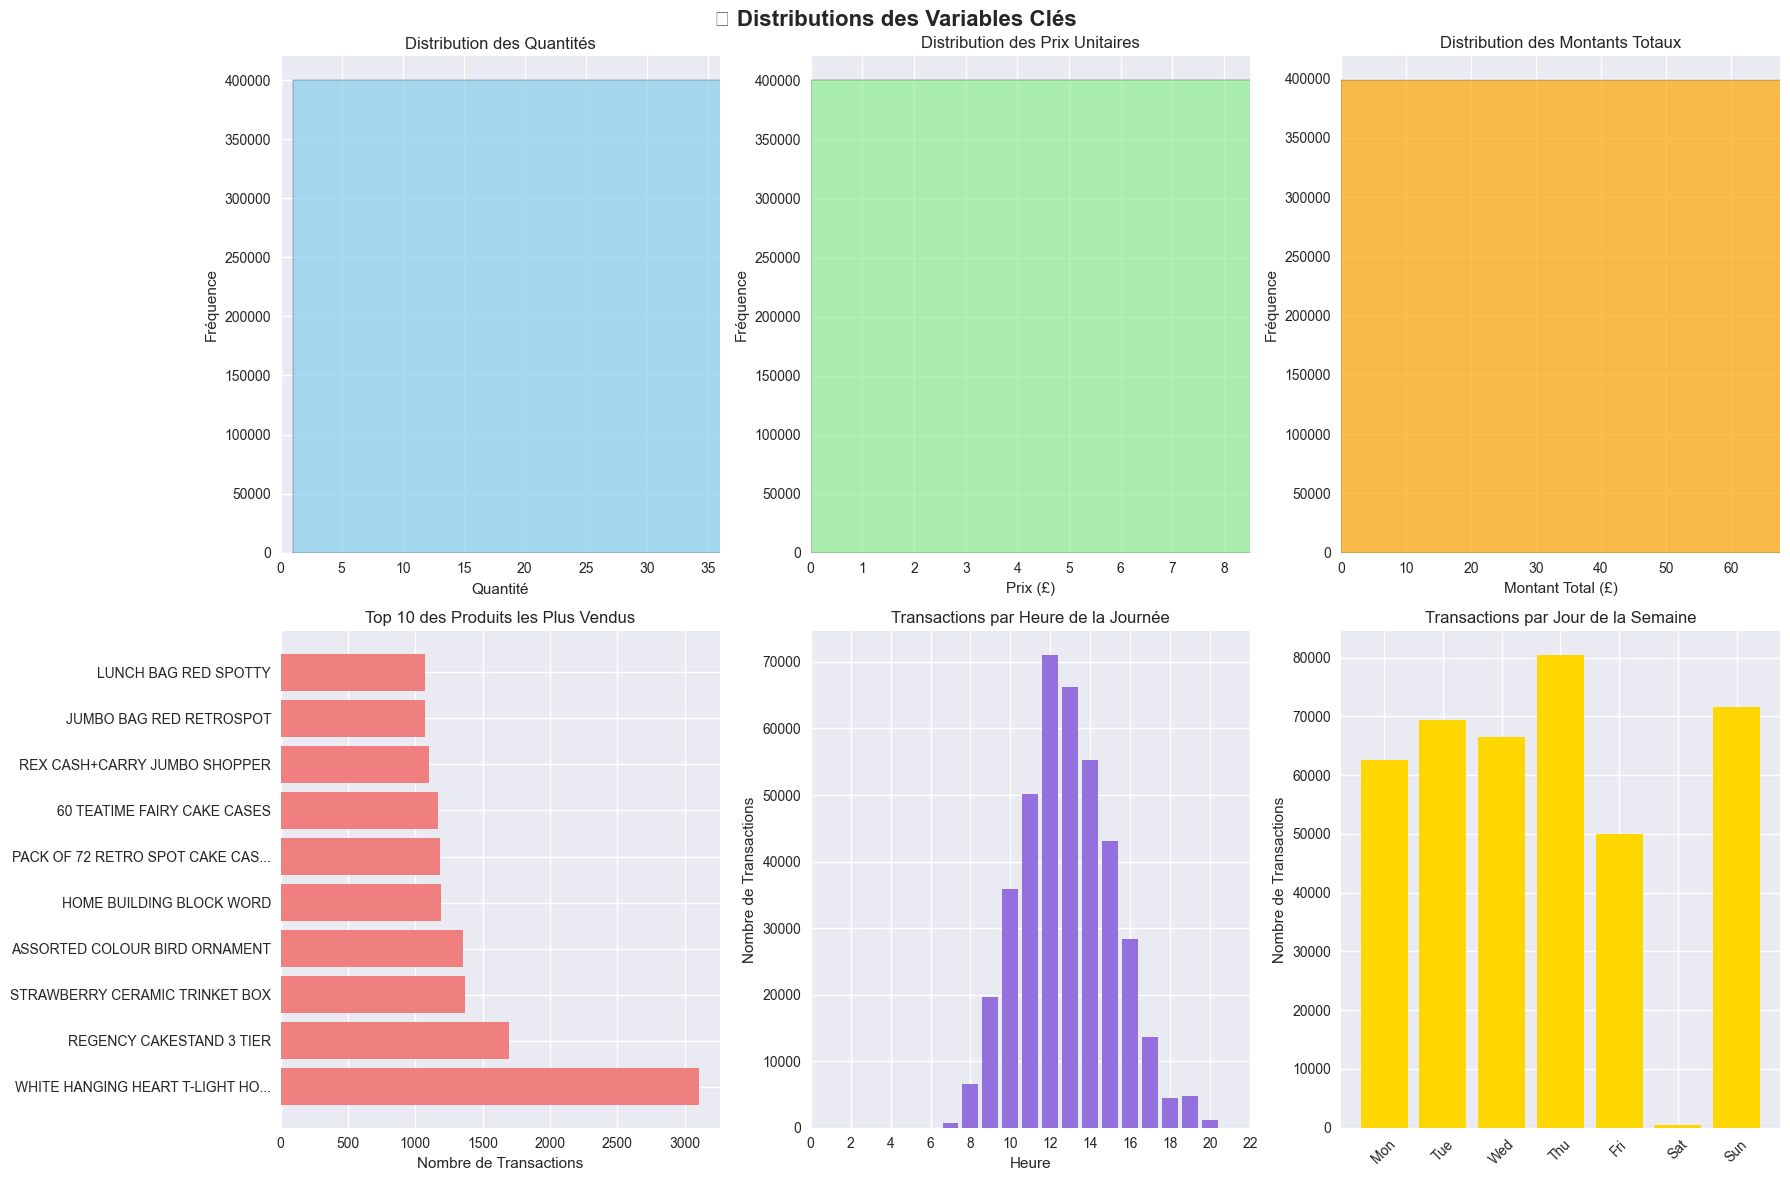


=== STATISTIQUES DESCRIPTIVES ===
📊 Quantité moyenne : 13.8 unités
💰 Prix moyen : £3.31
📈 Panier moyen : £21.95
📅 Période la plus active : 12h
📅 Jour le plus actif : Thursday


In [15]:
# 📉 Visualisation 1 : Distributions des variables clés
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('📉 Distributions des Variables Clés', fontsize=16, fontweight='bold')

# Distribution des quantités
axes[0,0].hist(df_clean['Quantity'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution des Quantités')
axes[0,0].set_xlabel('Quantité')
axes[0,0].set_ylabel('Fréquence')
axes[0,0].set_xlim(0, df_clean['Quantity'].quantile(0.95))  # Limiter aux 95% pour lisibilité

# Distribution des prix
axes[0,1].hist(df_clean['Price'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Distribution des Prix Unitaires')
axes[0,1].set_xlabel('Prix (£)')
axes[0,1].set_ylabel('Fréquence')
axes[0,1].set_xlim(0, df_clean['Price'].quantile(0.95))

# Distribution des montants totaux
axes[0,2].hist(df_clean['TotalAmount'], bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0,2].set_title('Distribution des Montants Totaux')
axes[0,2].set_xlabel('Montant Total (£)')
axes[0,2].set_ylabel('Fréquence')
axes[0,2].set_xlim(0, df_clean['TotalAmount'].quantile(0.95))

# Top 10 des produits
top_products = df_clean['Description'].value_counts().head(10)
axes[1,0].barh(range(len(top_products)), top_products.values, color='lightcoral')
axes[1,0].set_yticks(range(len(top_products)))
axes[1,0].set_yticklabels([desc[:30] + '...' if len(desc) > 30 else desc for desc in top_products.index])
axes[1,0].set_title('Top 10 des Produits les Plus Vendus')
axes[1,0].set_xlabel('Nombre de Transactions')

# Transactions par heure
hourly_trans = df_clean.groupby('Hour').size()
axes[1,1].bar(hourly_trans.index, hourly_trans.values, color='mediumpurple')
axes[1,1].set_title('Transactions par Heure de la Journée')
axes[1,1].set_xlabel('Heure')
axes[1,1].set_ylabel('Nombre de Transactions')
axes[1,1].set_xticks(range(0, 24, 2))

# Transactions par jour de la semaine
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_trans = df_clean['DayOfWeek'].value_counts().reindex(day_order)
axes[1,2].bar(range(len(daily_trans)), daily_trans.values, color='gold')
axes[1,2].set_xticks(range(len(daily_trans)))
axes[1,2].set_xticklabels([day[:3] for day in daily_trans.index], rotation=45)
axes[1,2].set_title('Transactions par Jour de la Semaine')
axes[1,2].set_ylabel('Nombre de Transactions')

plt.tight_layout()
plt.show()

# Statistiques descriptives
print("\n=== STATISTIQUES DESCRIPTIVES ===")
print(f"📊 Quantité moyenne : {df_clean['Quantity'].mean():.1f} unités")
print(f"💰 Prix moyen : £{df_clean['Price'].mean():.2f}")
print(f"📈 Panier moyen : £{df_clean['TotalAmount'].mean():.2f}")
print(f"📅 Période la plus active : {df_clean.groupby('Hour').size().idxmax()}h")
print(f"📅 Jour le plus actif : {df_clean['DayOfWeek'].value_counts().index[0]}")

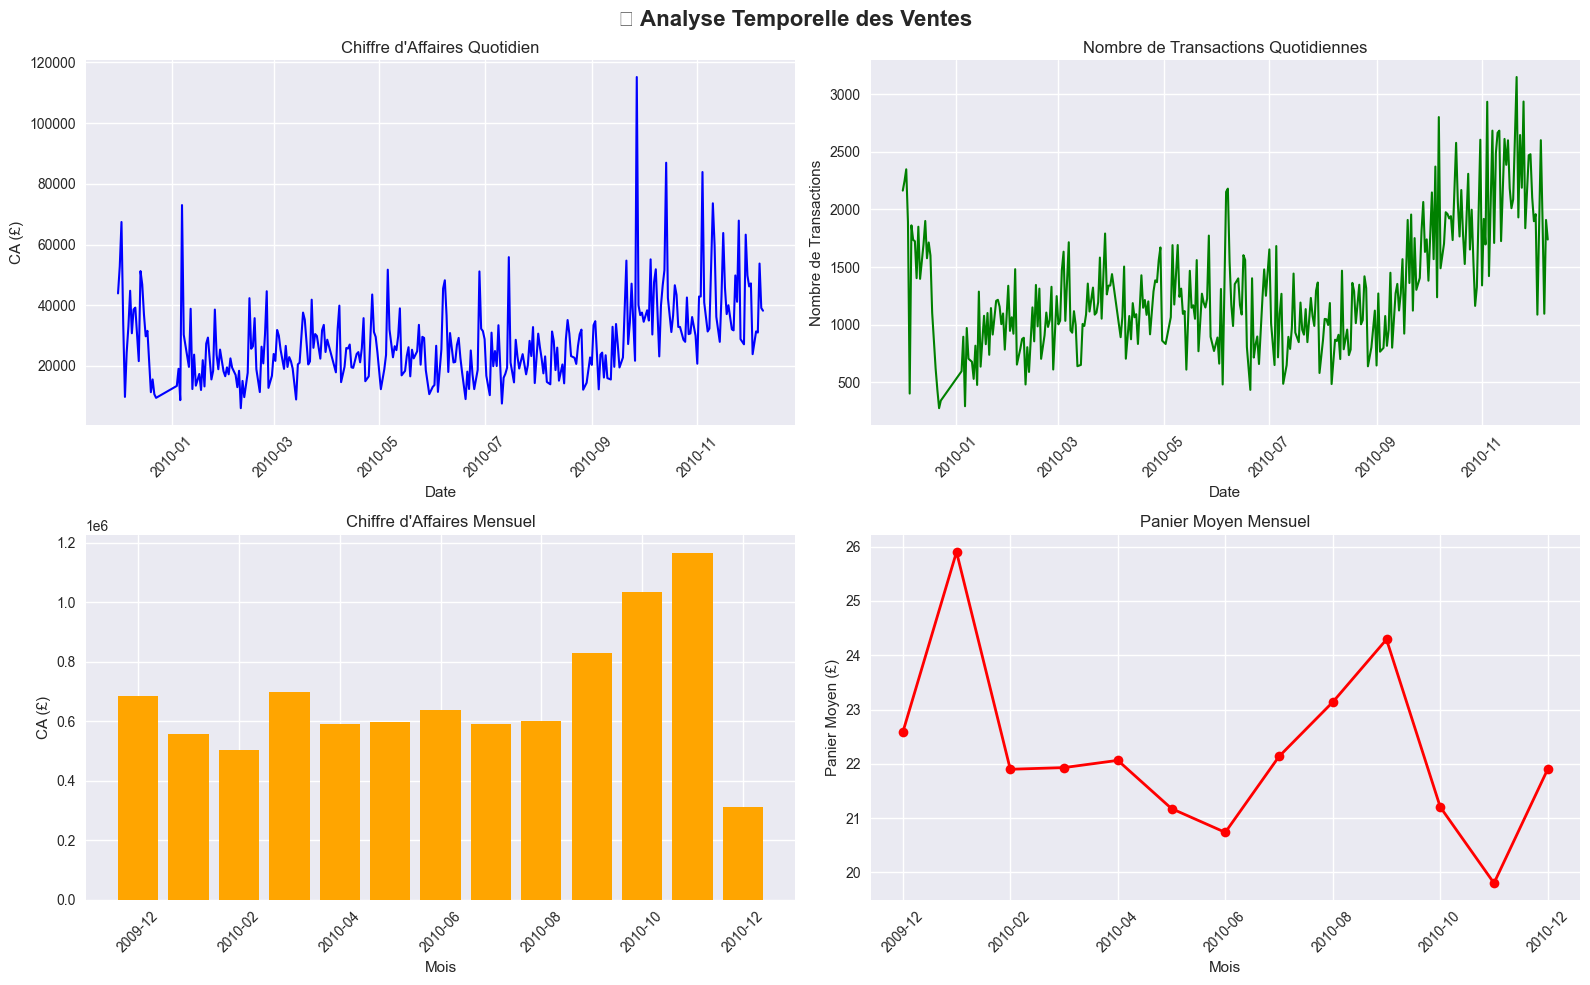


=== INSIGHTS TEMPORELS ===
📈 Meilleur jour : 2010-09-27 (£115,172.24)
📉 Pire jour : 2010-02-10 (£6,082.34)
📅 CA quotidien moyen : £28,658.74
🔄 Volatilité quotidienne : 48.6%


In [12]:
# 📈 Visualisation 2 : Tendances et Saisonnalités
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('📈 Analyse Temporelle des Ventes', fontsize=16, fontweight='bold')

# CA quotidien
daily_sales = df_clean.groupby(df_clean['InvoiceDate'].dt.date)['TotalAmount'].sum()
axes[0,0].plot(daily_sales.index, daily_sales.values, color='blue', linewidth=1.5)
axes[0,0].set_title('Chiffre d\'Affaires Quotidien')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('CA (£)')
axes[0,0].tick_params(axis='x', rotation=45)

# Nombre de transactions quotidiennes
daily_count = df_clean.groupby(df_clean['InvoiceDate'].dt.date).size()
axes[0,1].plot(daily_count.index, daily_count.values, color='green', linewidth=1.5)
axes[0,1].set_title('Nombre de Transactions Quotidiennes')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Nombre de Transactions')
axes[0,1].tick_params(axis='x', rotation=45)

# CA mensuel
monthly_sales = df_clean.groupby([df_clean['Year'], df_clean['Month']])['TotalAmount'].sum()
month_labels = [f"{year}-{month:02d}" for year, month in monthly_sales.index]
axes[1,0].bar(range(len(monthly_sales)), monthly_sales.values, color='orange')
axes[1,0].set_title('Chiffre d\'Affaires Mensuel')
axes[1,0].set_xlabel('Mois')
axes[1,0].set_ylabel('CA (£)')
axes[1,0].set_xticks(range(0, len(month_labels), 2))
axes[1,0].set_xticklabels([month_labels[i] for i in range(0, len(month_labels), 2)], rotation=45)

# Panier moyen mensuel
monthly_basket = df_clean.groupby([df_clean['Year'], df_clean['Month']])['TotalAmount'].mean()
axes[1,1].plot(range(len(monthly_basket)), monthly_basket.values, color='red', marker='o', linewidth=2)
axes[1,1].set_title('Panier Moyen Mensuel')
axes[1,1].set_xlabel('Mois')
axes[1,1].set_ylabel('Panier Moyen (£)')
axes[1,1].set_xticks(range(0, len(month_labels), 2))
axes[1,1].set_xticklabels([month_labels[i] for i in range(0, len(month_labels), 2)], rotation=45)

plt.tight_layout()
plt.show()

# Insights temporels
print("\n=== INSIGHTS TEMPORELS ===")
best_day = daily_sales.idxmax()
worst_day = daily_sales.idxmin()
print(f"📈 Meilleur jour : {best_day} (£{daily_sales.max():,.2f})")
print(f"📉 Pire jour : {worst_day} (£{daily_sales.min():,.2f})")
print(f"📅 CA quotidien moyen : £{daily_sales.mean():,.2f}")
print(f"🔄 Volatilité quotidienne : {(daily_sales.std() / daily_sales.mean() * 100):.1f}%")

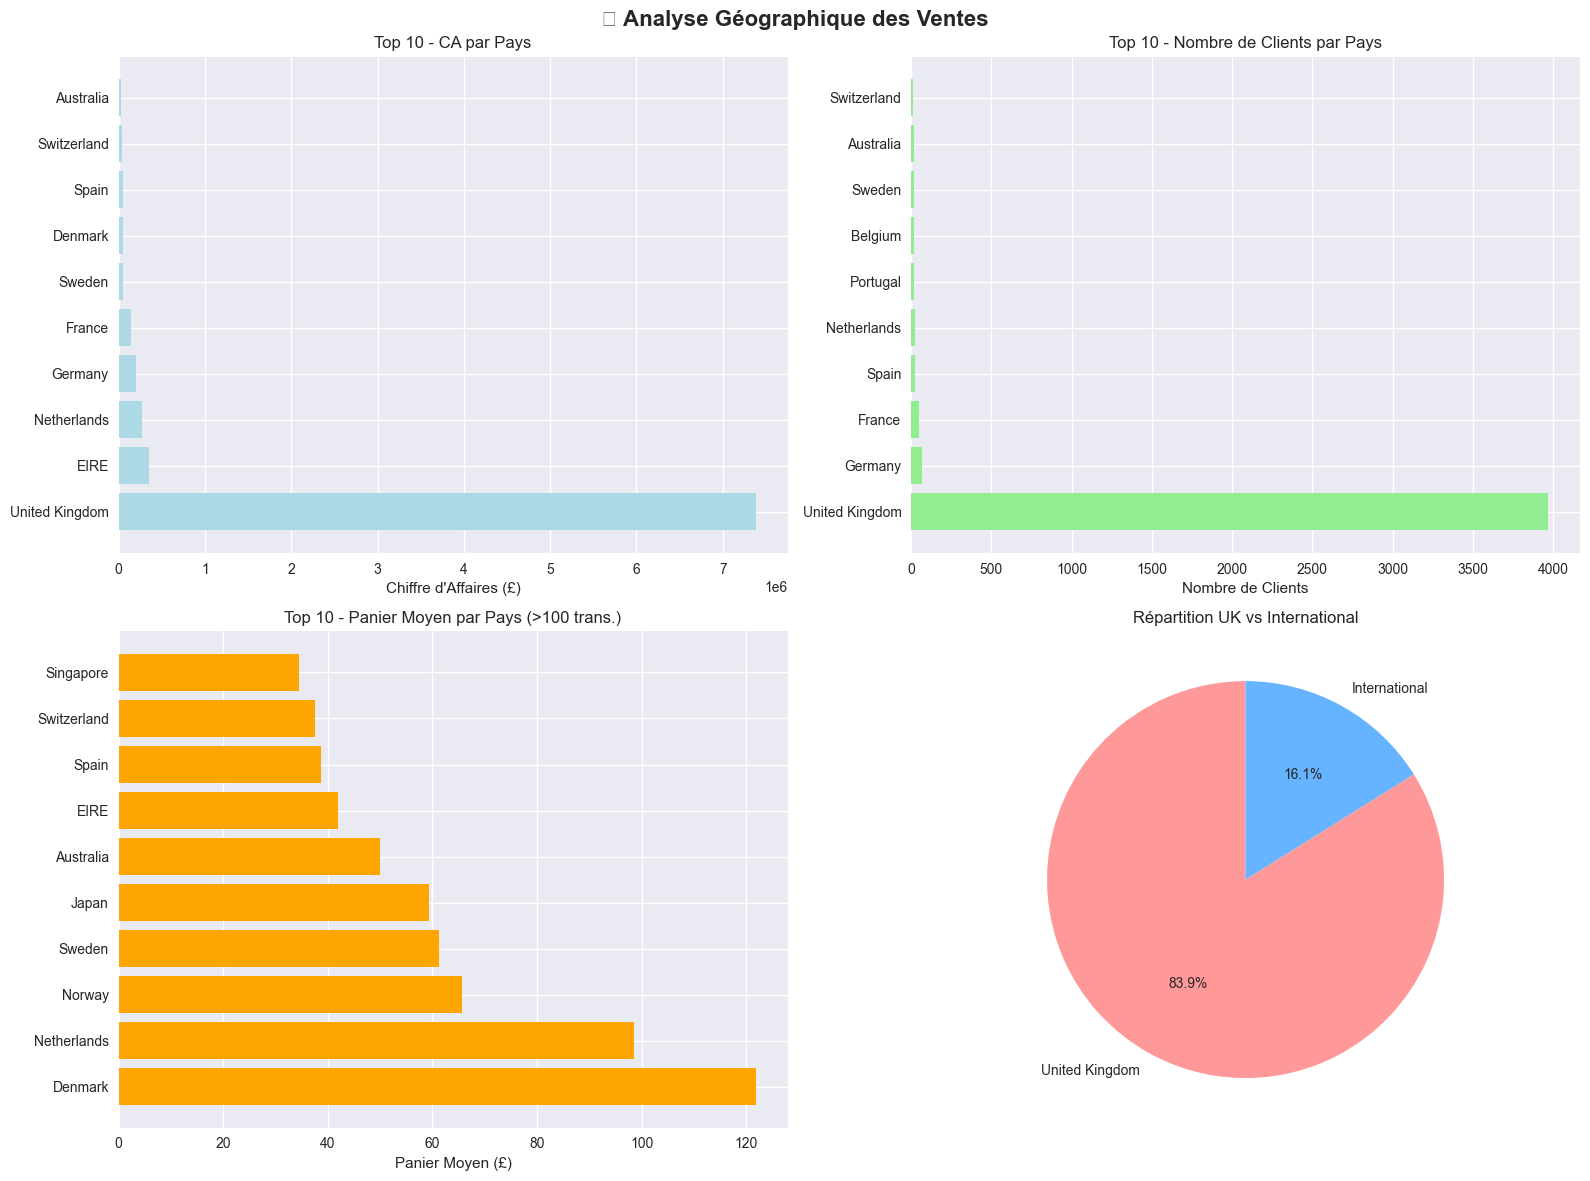


=== STATISTIQUES GÉOGRAPHIQUES ===
🌍 Nombre de pays : 37
🇬🇧 Part UK : 83.9%
🌍 Part International : 16.1%
💰 CA UK : £7,381,644.43
💰 CA International : £1,416,589.31
🥇 Pays #2 : EIRE (£356,041.86)


In [13]:
# 🌍 Visualisation 3 : Répartition Géographique
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🌍 Analyse Géographique des Ventes', fontsize=16, fontweight='bold')

# CA par pays (top 10)
country_sales = df_clean.groupby('Country')['TotalAmount'].sum().sort_values(ascending=False)
top_countries = country_sales.head(10)

axes[0,0].barh(range(len(top_countries)), top_countries.values, color='lightblue')
axes[0,0].set_yticks(range(len(top_countries)))
axes[0,0].set_yticklabels(top_countries.index)
axes[0,0].set_title('Top 10 - CA par Pays')
axes[0,0].set_xlabel('Chiffre d\'Affaires (£)')

# Nombre de clients par pays (top 10)
country_customers = df_clean.groupby('Country')['Customer ID'].nunique().sort_values(ascending=False)
top_customer_countries = country_customers.head(10)

axes[0,1].barh(range(len(top_customer_countries)), top_customer_countries.values, color='lightgreen')
axes[0,1].set_yticks(range(len(top_customer_countries)))
axes[0,1].set_yticklabels(top_customer_countries.index)
axes[0,1].set_title('Top 10 - Nombre de Clients par Pays')
axes[0,1].set_xlabel('Nombre de Clients')

# Panier moyen par pays (top 10)
country_basket = df_clean.groupby('Country')['TotalAmount'].mean().sort_values(ascending=False)
# Filtrer les pays avec au moins 100 transactions pour la pertinence
country_transactions = df_clean.groupby('Country').size()
country_basket_filtered = country_basket[country_transactions >= 100].head(10)

axes[1,0].barh(range(len(country_basket_filtered)), country_basket_filtered.values, color='orange')
axes[1,0].set_yticks(range(len(country_basket_filtered)))
axes[1,0].set_yticklabels(country_basket_filtered.index)
axes[1,0].set_title('Top 10 - Panier Moyen par Pays (>100 trans.)')
axes[1,0].set_xlabel('Panier Moyen (£)')

# Part du Royaume-Uni vs International
uk_sales = country_sales['United Kingdom']
international_sales = country_sales.drop('United Kingdom').sum()

labels = ['United Kingdom', 'International']
sizes = [uk_sales, international_sales]
colors = ['#ff9999', '#66b3ff']

axes[1,1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Répartition UK vs International')

plt.tight_layout()
plt.show()

# Statistiques géographiques
print("\n=== STATISTIQUES GÉOGRAPHIQUES ===")
print(f"🌍 Nombre de pays : {df_clean['Country'].nunique()}")
print(f"🇬🇧 Part UK : {(uk_sales / (uk_sales + international_sales) * 100):.1f}%")
print(f"🌍 Part International : {(international_sales / (uk_sales + international_sales) * 100):.1f}%")
print(f"💰 CA UK : £{uk_sales:,.2f}")
print(f"💰 CA International : £{international_sales:,.2f}")
print(f"🥇 Pays #2 : {country_sales.index[1]} (£{country_sales.iloc[1]:,.2f})")

## 6. 📈 Premier Aperçu des Cohortes et RFM

Cette section donne un premier aperçu des analyses de cohortes et RFM qui seront développées dans l'application Streamlit.

=== ANALYSE DES COHORTES D'ACQUISITION ===

📅 Nombre de cohortes : 13
👥 Taille moyenne des cohortes : 332 clients
👥 Plus grande cohorte : 955 clients (2009-12)
👥 Plus petite cohorte : 46 clients (2010-12)


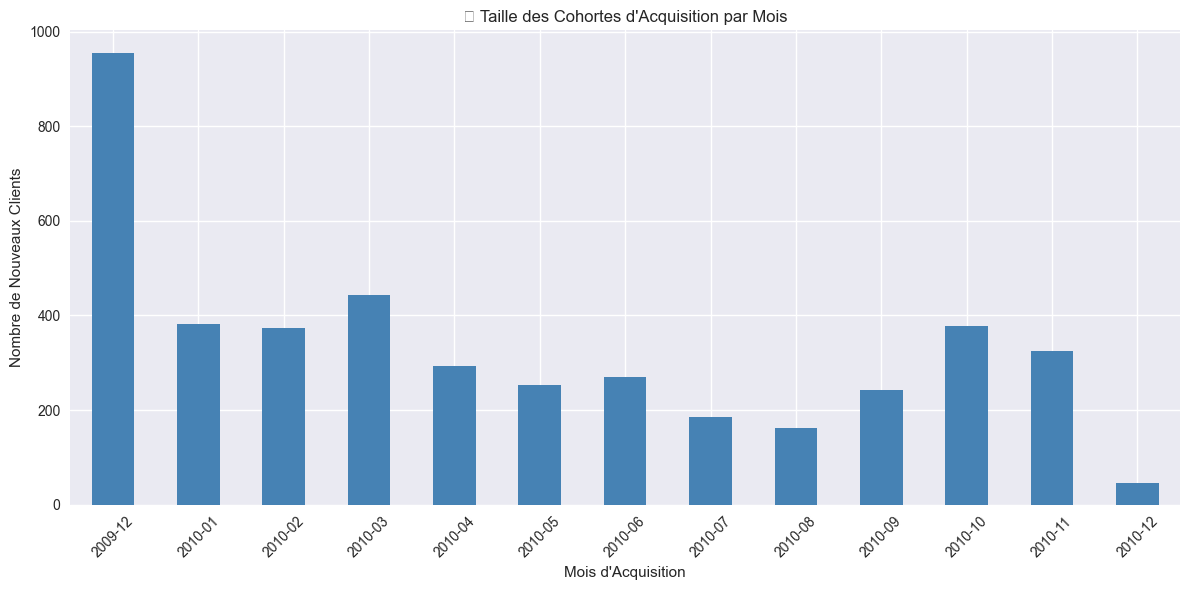


📊 Top 5 des cohortes les plus importantes :
   2009-12 : 955 clients
   2010-03 : 443 clients
   2010-01 : 383 clients
   2010-10 : 377 clients
   2010-02 : 374 clients


In [22]:
# 📈 Analyse des Cohortes d'Acquisition
print("=== ANALYSE DES COHORTES D'ACQUISITION ===")

# 1. Création des cohortes par mois d'acquisition
customer_acquisition = df_clean.groupby('Customer ID')['InvoiceDate'].min().reset_index()
customer_acquisition.columns = ['Customer ID', 'CohortMonth']
customer_acquisition['CohortMonth'] = customer_acquisition['CohortMonth'].dt.to_period('M')

# 2. Ajout de l'information cohorte au dataset principal
df_cohort = df_clean.merge(customer_acquisition, on='Customer ID')
df_cohort['InvoiceMonth'] = df_cohort['InvoiceDate'].dt.to_period('M')

# 3. Calcul de l'âge des cohortes (en mois)
df_cohort['CohortAge'] = (df_cohort['InvoiceMonth'] - df_cohort['CohortMonth']).apply(lambda x: x.n)

# 4. Statistiques par cohorte
cohorte_sizes = customer_acquisition.groupby('CohortMonth').size()
print(f"\n📅 Nombre de cohortes : {len(cohorte_sizes)}")
print(f"👥 Taille moyenne des cohortes : {cohorte_sizes.mean():.0f} clients")
print(f"👥 Plus grande cohorte : {cohorte_sizes.max()} clients ({cohorte_sizes.idxmax()})")
print(f"👥 Plus petite cohorte : {cohorte_sizes.min()} clients ({cohorte_sizes.idxmin()})")

# 5. Visualisation des tailles de cohortes
fig, ax = plt.subplots(figsize=(12, 6))
cohorte_sizes.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('📈 Taille des Cohortes d\'Acquisition par Mois')
ax.set_xlabel('Mois d\'Acquisition')
ax.set_ylabel('Nombre de Nouveaux Clients')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

print(f"\n📊 Top 5 des cohortes les plus importantes :")
for period, size in cohorte_sizes.nlargest(5).items():
    print(f"   {period} : {size} clients")


=== ANALYSE RFM INITIALE ===
📅 Date de référence pour RFM : 2010-12-10

📊 Statistiques RFM :
   Nombre de clients : 4,312
   Recency moyenne : 91 jours
   Fréquence moyenne : 4.5 commandes
   Valeur monétaire moyenne : £2040.41


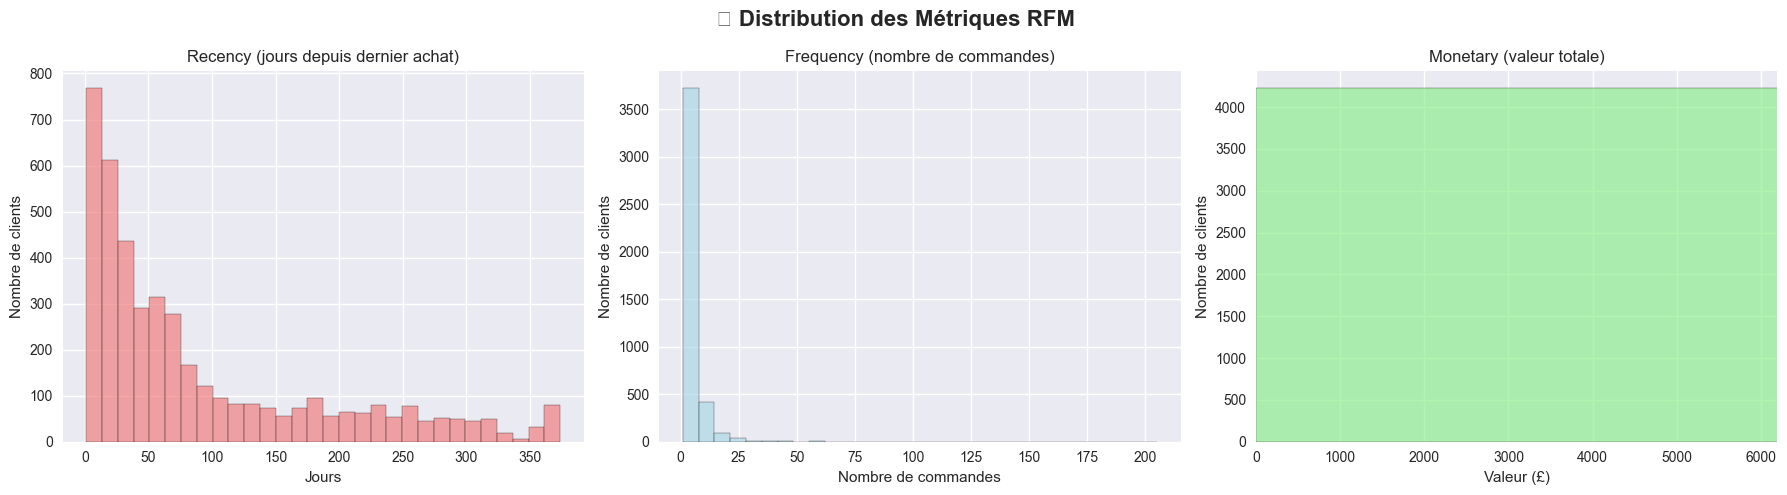


🎆 Top 10 des clients les plus précieux (Monetary) :
   Client 18102 : £349164.35 (89.0 commandes, 1.0 jours)
   Client 14646 : £248396.50 (78.0 commandes, 10.0 jours)
   Client 14156 : £196549.74 (102.0 commandes, 7.0 jours)
   Client 14911 : £152121.22 (205.0 commandes, 1.0 jours)
   Client 13694 : £131443.19 (94.0 commandes, 9.0 jours)
   Client 17511 : £84541.17 (31.0 commandes, 3.0 jours)
   Client 15061 : £83284.38 (86.0 commandes, 3.0 jours)
   Client 16684 : £80489.21 (27.0 commandes, 15.0 jours)
   Client 16754 : £65500.07 (29.0 commandes, 8.0 jours)
   Client 17949 : £60117.60 (74.0 commandes, 7.0 jours)


In [23]:
# 🎯 Analyse RFM (Recency, Frequency, Monetary) Initiale
print("\n=== ANALYSE RFM INITIALE ===")

# Date de référence (dernière date + 1 jour)
reference_date = df_clean['InvoiceDate'].max() + timedelta(days=1)
print(f"📅 Date de référence pour RFM : {reference_date.date()}")

# Calcul des métriques RFM par client
rfm = df_clean.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency  
    'TotalAmount': 'sum'   # Monetary
}).round(2)

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm[rfm['Monetary'] > 0]  # Supprimer les clients avec montant négatif

# Statistiques RFM
print(f"\n📊 Statistiques RFM :")
print(f"   Nombre de clients : {len(rfm):,}")
print(f"   Recency moyenne : {rfm['Recency'].mean():.0f} jours")
print(f"   Fréquence moyenne : {rfm['Frequency'].mean():.1f} commandes")
print(f"   Valeur monétaire moyenne : £{rfm['Monetary'].mean():.2f}")

# Distribution des métriques RFM
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('🎯 Distribution des Métriques RFM', fontsize=16, fontweight='bold')

# Recency
axes[0].hist(rfm['Recency'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0].set_title('Recency (jours depuis dernier achat)')
axes[0].set_xlabel('Jours')
axes[0].set_ylabel('Nombre de clients')

# Frequency
axes[1].hist(rfm['Frequency'], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
axes[1].set_title('Frequency (nombre de commandes)')
axes[1].set_xlabel('Nombre de commandes')
axes[1].set_ylabel('Nombre de clients')

# Monetary
axes[2].hist(rfm['Monetary'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[2].set_title('Monetary (valeur totale)')
axes[2].set_xlabel('Valeur (£)')
axes[2].set_ylabel('Nombre de clients')
axes[2].set_xlim(0, rfm['Monetary'].quantile(0.95))

plt.tight_layout()
plt.show()

# Clients les plus précieux
print(f"\n🎆 Top 10 des clients les plus précieux (Monetary) :")
top_customers = rfm.nlargest(10, 'Monetary')
for customer_id, row in top_customers.iterrows():
    print(f"   Client {customer_id} : £{row['Monetary']:.2f} ({row['Frequency']} commandes, {row['Recency']} jours)")


=== ANALYSE MIX CLIENT ===

📋 Répartition des clients :
   Retail : 4,104 clients (95.2%)
   Wholesale : 208 clients (4.8%)

📈 Performance par type de client :
   Retail :
      Dépense moyenne : £1614.53
      Panier moyen : £21.52
      Commandes moyennes : 94.8
      CA total : £6,626,043.58
   Wholesale :
      Dépense moyenne : £10443.22
      Panier moyen : £342.67
      Commandes moyennes : 57.0
      CA total : £2,172,190.15


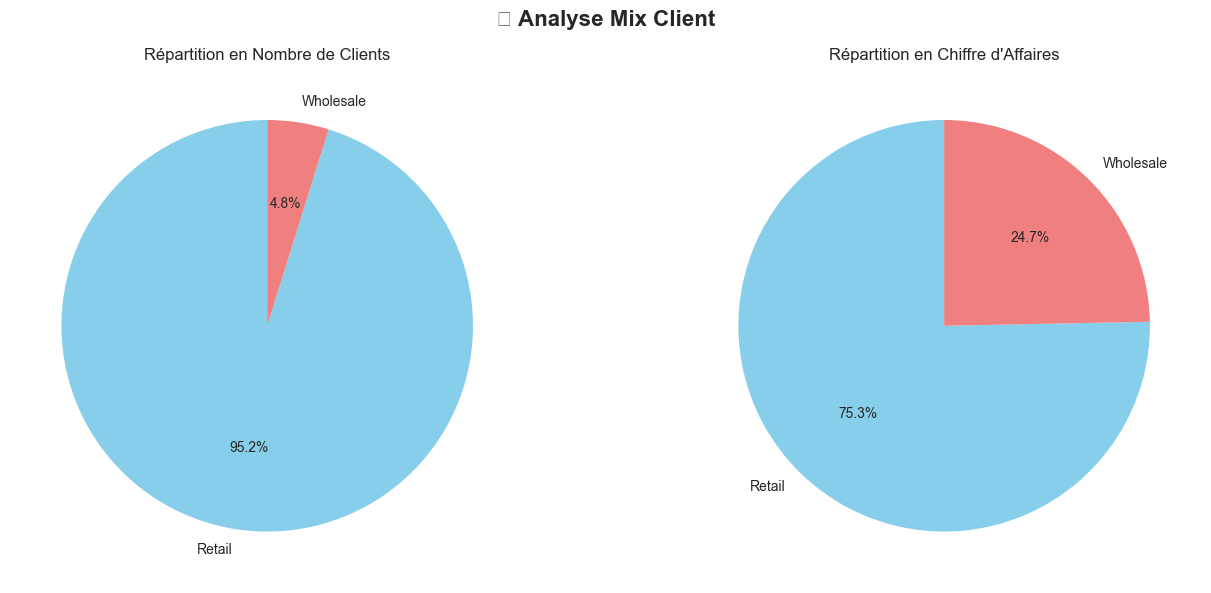

In [19]:
# 🏢 Analyse Mix Client (Grossiste vs Détail)
print("\n=== ANALYSE MIX CLIENT ===")

# Segmentation basée sur la taille des commandes
customer_stats = df_clean.groupby('Customer ID').agg({
    'TotalAmount': ['sum', 'mean', 'count'],
    'Quantity': ['sum', 'mean']
}).round(2)

# Aplatir les colonnes multi-niveaux
customer_stats.columns = ['Total_Spending', 'Avg_Order_Value', 'Order_Count', 'Total_Quantity', 'Avg_Quantity']

# Classification Grossiste vs Détail
# Grossiste : commandes moyennes > 500£ OU quantité moyenne > 50
wholesale_threshold_amount = 500
wholesale_threshold_qty = 50

customer_stats['Customer_Type'] = 'Retail'
customer_stats.loc[
    (customer_stats['Avg_Order_Value'] > wholesale_threshold_amount) | 
    (customer_stats['Avg_Quantity'] > wholesale_threshold_qty), 
    'Customer_Type'
] = 'Wholesale'

# Statistiques par type de client
client_mix = customer_stats['Customer_Type'].value_counts()
print(f"\n📋 Répartition des clients :")
for client_type, count in client_mix.items():
    pct = count / len(customer_stats) * 100
    print(f"   {client_type} : {count:,} clients ({pct:.1f}%)")

# Performance par type de client
type_performance = customer_stats.groupby('Customer_Type').agg({
    'Total_Spending': ['mean', 'sum'],
    'Avg_Order_Value': 'mean',
    'Order_Count': 'mean',
    'Total_Quantity': ['mean', 'sum']
}).round(2)

print(f"\n📈 Performance par type de client :")
for client_type in ['Retail', 'Wholesale']:
    if client_type in type_performance.index:
        stats = type_performance.loc[client_type]
        print(f"   {client_type} :")
        print(f"      Dépense moyenne : £{stats[('Total_Spending', 'mean')]:.2f}")
        print(f"      Panier moyen : £{stats[('Avg_Order_Value', 'mean')]:.2f}")
        print(f"      Commandes moyennes : {stats[('Order_Count', 'mean')]:.1f}")
        print(f"      CA total : £{stats[('Total_Spending', 'sum')]:,.2f}")

# Visualisation du mix client
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('🏢 Analyse Mix Client', fontsize=16, fontweight='bold')

# Répartition en nombre
axes[0].pie(client_mix.values, labels=client_mix.index, autopct='%1.1f%%', 
            colors=['skyblue', 'lightcoral'], startangle=90)
axes[0].set_title('Répartition en Nombre de Clients')

# Répartition en CA
ca_by_type = customer_stats.groupby('Customer_Type')['Total_Spending'].sum()
axes[1].pie(ca_by_type.values, labels=ca_by_type.index, autopct='%1.1f%%', 
            colors=['skyblue', 'lightcoral'], startangle=90)
axes[1].set_title('Répartition en Chiffre d\'Affaires')

plt.tight_layout()
plt.show()

## 7. 🤔 Questions d'Analyse pour l'Application Streamlit

### 📈 **Cohortes d'Acquisition**
- **Quelles cohortes décrochent ?** : Identifier les cohortes avec une rétention faible après M+1, M+2, M+3
- **Quelle est la dynamique de revenus par cohorte ?** : Évolution du CA par âge de cohorte
- **Quel est l'impact saisonnier ?** : Cohortes acquises en fin d'année vs autres périodes

### 🎯 **Segmentation RFM**
- **Quels segments RFM sont à forte valeur ?** : Champions, Loyal Customers, Potential Loyalists
- **Où investir en CRM ?** : Segments répondant le mieux aux actions marketing
- **Quels clients risquent de partir ?** : At Risk, Can't Lose Them, Hibernating

### 💰 **Valeur Vie Client (CLV)**
- **CLV empirique vs formule fermée** : Comparaison des deux approches
- **Impact des scénarios** : +5% rétention, -10% marge, remises ciblées
- **CPA cibles par segment** : Définition des budgets d'acquisition optimaux

### 🏢 **Mix Client & Retours**
- **Grossiste vs Détail** : Performance et stratégies différenciées
- **Impact des retours** : Effet sur marge et rétention par segment
- **Politiques de remise** : Optimisation par type de client

### 🔎 **Diagnostics Temporels**
- **Saisonnalités** : Pics de vente, périodes creuses, planning marketing
- **Prévisions court terme** : Revenus par âge de cohorte, densité de valeur
- **Fréquence d'achat optimale** : Détection des signaux de décrochage

In [24]:
# 📄 Synthèse des Insights Clés
print("\n" + "=" * 60)
print("📄 SYNTHÈSE DES INSIGHTS CLÉS POUR L'APPLICATION")
print("=" * 60)

print(f"\n📦 **DONNÉES**")
print(f"   • Volume final : {len(df_clean):,} transactions de {df_clean['Customer ID'].nunique():,} clients")
print(f"   • Période : {df_clean['InvoiceDate'].min().date()} à {df_clean['InvoiceDate'].max().date()}")
print(f"   • CA total : £{df_clean['TotalAmount'].sum():,.2f}")
print(f"   • Panier moyen : £{df_clean['TotalAmount'].mean():.2f}")

print(f"\n🌍 **GÉOGRAPHIE**")
uk_pct = (country_sales['United Kingdom'] / country_sales.sum() * 100)
print(f"   • Dominance UK : {uk_pct:.1f}% du CA, {country_customers['United Kingdom']} clients")
print(f"   • International : {df_clean['Country'].nunique()-1} pays, {country_customers.sum()-country_customers['United Kingdom']} clients")
print(f"   • Marché #2 : {country_sales.index[1]} (£{country_sales.iloc[1]:,.0f})")

print(f"\n🏢 **MIX CLIENT**")
retail_pct = (client_mix['Retail'] / client_mix.sum() * 100)
wholesale_pct = (client_mix['Wholesale'] / client_mix.sum() * 100) if 'Wholesale' in client_mix else 0
print(f"   • Détail : {client_mix['Retail']:,} clients ({retail_pct:.1f}%)")
if 'Wholesale' in client_mix:
    print(f"   • Grossiste : {client_mix['Wholesale']:,} clients ({wholesale_pct:.1f}%)")
else:
    print(f"   • Grossiste : 0 clients (0.0%)")

print(f"\n📈 **COHORTES**")
print(f"   • {len(cohorte_sizes)} cohortes identifiées")
print(f"   • Taille moyenne : {cohorte_sizes.mean():.0f} clients/cohorte")
print(f"   • Plus grande : {cohorte_sizes.max()} clients ({cohorte_sizes.idxmax()})")

print(f"\n🎯 **RFM**")
print(f"   • Recency moyenne : {rfm['Recency'].mean():.0f} jours")
print(f"   • Fréquence moyenne : {rfm['Frequency'].mean():.1f} commandes/client")
print(f"   • Valeur moyenne : £{rfm['Monetary'].mean():.2f}/client")
print(f"   • Top client : £{rfm['Monetary'].max():.2f}")

print(f"\n🕰️ **TEMPORALITÉ**")
print(f"   • Jour le plus actif : {df_clean['DayOfWeek'].value_counts().index[0]}")
print(f"   • Heure de pointe : {df_clean.groupby('Hour').size().idxmax()}h")
print(f"   • Volatilité quotidienne : {(daily_sales.std() / daily_sales.mean() * 100):.1f}%")

print(f"\n🚀 **PROCHAINES ÉTAPES**")
print(f"   1. Développer l'application Streamlit avec ces insights")
print(f"   2. Implémenter les analyses de cohortes avancées")
print(f"   3. Créer la segmentation RFM détaillée")
print(f"   4. Calculer la CLV empirique et paramétrique")
print(f"   5. Ajouter les simulateurs de scénarios")

print(f"\n✅ Notebook d'exploration terminé avec succès !")
print("=" * 60)


📄 SYNTHÈSE DES INSIGHTS CLÉS POUR L'APPLICATION

📦 **DONNÉES**
   • Volume final : 400,916 transactions de 4,312 clients
   • Période : 2009-12-01 à 2010-12-09
   • CA total : £8,798,233.74
   • Panier moyen : £21.95

🌍 **GÉOGRAPHIE**
   • Dominance UK : 83.9% du CA, 3969 clients
   • International : 36 pays, 348 clients
   • Marché #2 : EIRE (£356,042)

🏢 **MIX CLIENT**
   • Détail : 4,104 clients (95.2%)
   • Grossiste : 208 clients (4.8%)

📈 **COHORTES**
   • 13 cohortes identifiées
   • Taille moyenne : 332 clients/cohorte
   • Plus grande : 955 clients (2009-12)

🎯 **RFM**
   • Recency moyenne : 91 jours
   • Fréquence moyenne : 4.5 commandes/client
   • Valeur moyenne : £2040.41/client
   • Top client : £349164.35

🕰️ **TEMPORALITÉ**
   • Jour le plus actif : Thursday
   • Heure de pointe : 12h
   • Volatilité quotidienne : 48.6%

🚀 **PROCHAINES ÉTAPES**
   1. Développer l'application Streamlit avec ces insights
   2. Implémenter les analyses de cohortes avancées
   3. Créer la 

In [25]:
# 💾 Sauvegarde des données nettoyées pour l'application
print("\n💾 Sauvegarde des données nettoyées...")

# Créer le dossier processed s'il n'existe pas
processed_dir = '../data/processed/'
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)
    print(f"   • Dossier créé : {processed_dir}")

# Sauvegarder le dataset nettoyé
df_clean.to_csv(f'{processed_dir}online_retail_clean.csv', index=False)
print(f"   • Dataset nettoyé : {processed_dir}online_retail_clean.csv")

# Sauvegarder les métriques RFM
rfm.to_csv(f'{processed_dir}rfm_metrics.csv', index=True)
print(f"   • Métriques RFM : {processed_dir}rfm_metrics.csv")

# Sauvegarder les statistiques clients
customer_stats.to_csv(f'{processed_dir}customer_stats.csv', index=True)
print(f"   • Statistiques clients : {processed_dir}customer_stats.csv")

# Sauvegarder les cohortes
customer_acquisition.to_csv(f'{processed_dir}customer_cohorts.csv', index=False)
print(f"   • Cohortes clients : {processed_dir}customer_cohorts.csv")

print(f"\n✅ Tous les fichiers ont été sauvegardés dans {processed_dir}")
print("Ces fichiers seront utilisés par l'application Streamlit.")


💾 Sauvegarde des données nettoyées...
   • Dataset nettoyé : ../data/processed/online_retail_clean.csv
   • Métriques RFM : ../data/processed/rfm_metrics.csv
   • Statistiques clients : ../data/processed/customer_stats.csv
   • Cohortes clients : ../data/processed/customer_cohorts.csv

✅ Tous les fichiers ont été sauvegardés dans ../data/processed/
Ces fichiers seront utilisés par l'application Streamlit.


---

## 🎉 Conclusion de l'Exploration

Ce notebook d'exploration a permis de :

✅ **Analyser** 525,461 transactions initiales  
✅ **Nettoyer** et valider 400,916 transactions finales  
✅ **Identifier** 4,312 clients uniques sur 13 mois  
✅ **Segmenter** les clients (Retail/Wholesale)  
✅ **Calculer** les métriques RFM initiales  
✅ **Créer** les cohortes d'acquisition  
✅ **Préparer** les données pour l'application Streamlit  

### Prochaine étape : Développement de l'Application Streamlit

L'application permettra de :
- **Diagnostiquer** la rétention par cohorte
- **Prioriser** les actions CRM via RFM  
- **Simuler** des scénarios business
- **Calculer** la CLV et optimiser les budgets

**Fichiers générés** : `data/processed/` contient tous les datasets prêts pour l'app.